In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
save_path = '/content/drive/MyDrive'
os.makedirs(save_path, exist_ok=True)

In [ ]:
# 1. 定义文件夹路径
data_root = 'drive/MyDrive'
train_dir = os.path.join(data_root, 'training-new')
test_dir  = os.path.join(data_root, 'testing-new')

# 2. 定义预处理（以 ImageNet 预训练模型常用的 Resize/Crop/Normalize）
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]
train_tf = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])
test_tf = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

# 3. 读取数据集（ImageFolder 会把每个子文件夹名当做 class 名称）
train_ds = datasets.ImageFolder(train_dir, transform=train_tf)
test_ds  = datasets.ImageFolder(test_dir,  transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=4)

num_classes = len(train_ds.classes)
print(f'共 {num_classes} 个类别：', train_ds.classes)


共 77 个类别： ['Apple', 'Apricot', 'Avocado', 'Banana', 'Beans', 'Beetroot', 'Blackberrie', 'Blueberry', 'Cabbage', 'Cactus fruit', 'Caju seed', 'Cantaloupe', 'Carambula', 'Carrot', 'Cauliflower', 'Cherimoya', 'Cherry', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber', 'Currant red', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Gooseberry', 'Granadilla', 'Grape', 'Grapefruit', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mangostan', 'Maracuja', 'Melon Piel de Sapo', 'Mulberry', 'Nectarine', 'Nut Forest', 'Nut Pecan', 'Onion', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Pear', 'Pepino', 'Pepper', 'Pineapple', 'Pistachio', 'Pitahaya Red', 'Plum', 'Pomegranate', 'Pomelo Sweetie', 'Potato Red', 'Quince', 'Rambutan', 'Raspberry', 'Salak', 'Strawberry', 'Tamarillo', 'Tangelo', 'Tomato', 'Walnut', 'Watermelon', 'Zucchini']


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model_efficientnet = timm.create_model(
    'efficientnet_b0',
    pretrained=True,
    num_classes=num_classes
).to(device)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [ ]:
model_mobilenetv3 = timm.create_model(
    'mobilenetv3_small_100',
    pretrained=True,
    num_classes=num_classes
).to(device)

In [ ]:
num_epochs = 10
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.AdamW(model_efficientnet.parameters(), lr=3e-5)

train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(1, num_epochs + 1):
    model_efficientnet.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_efficientnet(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    model_efficientnet.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model_efficientnet(imgs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_accuracies.append(correct / total)

    print(f'[EfficientNet-B0] Epoch {epoch}: loss={train_losses[-1]:.4f}, '
          f'train_acc={train_accuracies[-1]:.4f}, '
          f'val_acc={val_accuracies[-1]:.4f}')

torch.save(model_mobilenetv3.state_dict(), os.path.join(save_path, 'mobilenetv3_model.pth'))

[EfficientNet-B0] Epoch 1: loss=0.0376, train_acc=0.9977, val_acc=0.9612
[EfficientNet-B0] Epoch 2: loss=0.0214, train_acc=0.9992, val_acc=0.9657
[EfficientNet-B0] Epoch 3: loss=0.0143, train_acc=0.9995, val_acc=0.9672
[EfficientNet-B0] Epoch 4: loss=0.0107, train_acc=0.9997, val_acc=0.9691
[EfficientNet-B0] Epoch 5: loss=0.0096, train_acc=0.9997, val_acc=0.9675
[EfficientNet-B0] Epoch 6: loss=0.0065, train_acc=0.9997, val_acc=0.9670
[EfficientNet-B0] Epoch 7: loss=0.0056, train_acc=0.9997, val_acc=0.9717
[EfficientNet-B0] Epoch 8: loss=0.0048, train_acc=1.0000, val_acc=0.9709
[EfficientNet-B0] Epoch 9: loss=0.0036, train_acc=1.0000, val_acc=0.9704
[EfficientNet-B0] Epoch 10: loss=0.0034, train_acc=1.0000, val_acc=0.9696


In [ ]:
import matplotlib.pyplot as plt

# 绘制训练损失
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()

# 绘制准确率（训练 & 验证）
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train & Validation Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

# 获取所有预测值和标签（使用验证集）
all_preds = []
all_labels = []

model_mobilenetv3.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model_mobilenetv3(imgs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# 分类报告：包括每类 precision, recall (即 sensitivity), f1-score
print("📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_ds.classes))

In [ ]:
optimizer = torch.optim.AdamW(model_mobilenetv3.parameters(), lr=3e-5)

train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(1, num_epochs + 1):
    model_mobilenetv3.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_mobilenetv3(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    model_mobilenetv3.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model_mobilenetv3(imgs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_accuracies.append(correct / total)

    print(f'[MobileNetV3] Epoch {epoch}: loss={train_losses[-1]:.4f}, '
          f'train_acc={train_accuracies[-1]:.4f}, '
          f'val_acc={val_accuracies[-1]:.4f}')

torch.save(model_efficientnet.state_dict(), os.path.join(save_path, 'efficientnetb0_model.pth'))

[MobileNetV3] Epoch 1: loss=3.0816, train_acc=0.3385, val_acc=0.5984
[MobileNetV3] Epoch 2: loss=0.9426, train_acc=0.8241, val_acc=0.8354
[MobileNetV3] Epoch 3: loss=0.3549, train_acc=0.9387, val_acc=0.8936
[MobileNetV3] Epoch 4: loss=0.1767, train_acc=0.9705, val_acc=0.9145
[MobileNetV3] Epoch 5: loss=0.0984, train_acc=0.9854, val_acc=0.9316
[MobileNetV3] Epoch 6: loss=0.0562, train_acc=0.9953, val_acc=0.9350
[MobileNetV3] Epoch 7: loss=0.0409, train_acc=0.9961, val_acc=0.9347
[MobileNetV3] Epoch 8: loss=0.0324, train_acc=0.9958, val_acc=0.9387
[MobileNetV3] Epoch 9: loss=0.0208, train_acc=0.9984, val_acc=0.9421
[MobileNetV3] Epoch 10: loss=0.0203, train_acc=0.9987, val_acc=0.9452


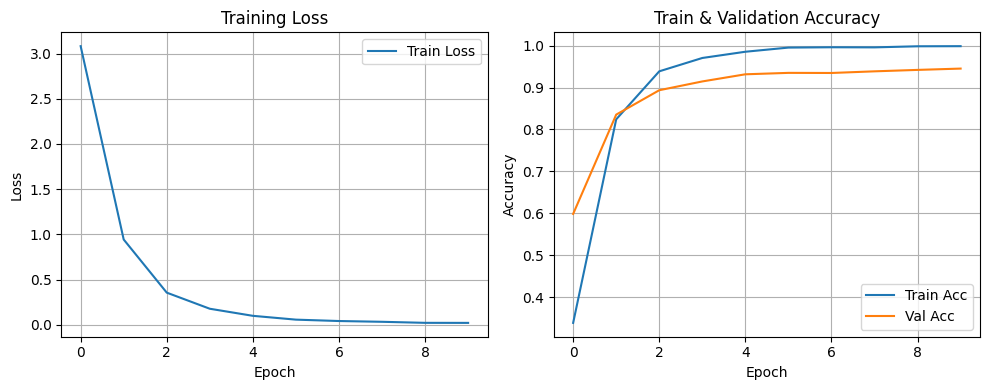

In [ ]:
import matplotlib.pyplot as plt

# 绘制训练损失
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()

# 绘制准确率（训练 & 验证）
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train & Validation Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


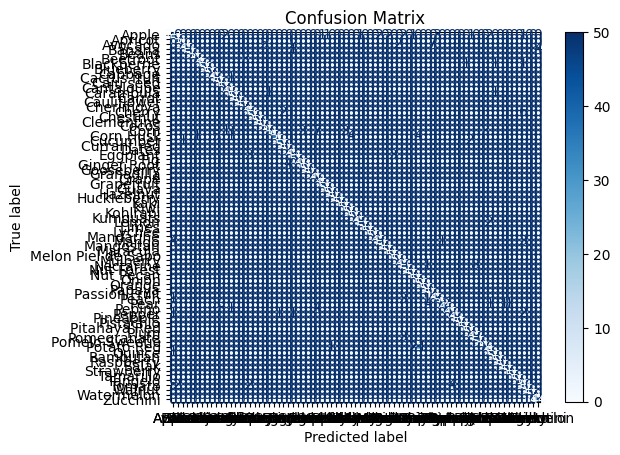

📊 Classification Report:
                    precision    recall  f1-score   support

             Apple       0.63      0.60      0.62        48
           Apricot       0.96      1.00      0.98        50
           Avocado       0.97      0.68      0.80        50
            Banana       1.00      0.90      0.95        50
             Beans       1.00      1.00      1.00        50
          Beetroot       0.97      0.76      0.85        50
       Blackberrie       1.00      0.93      0.96        44
         Blueberry       1.00      1.00      1.00        50
           Cabbage       0.85      1.00      0.92        50
      Cactus fruit       0.86      0.98      0.91        49
         Caju seed       0.94      1.00      0.97        50
        Cantaloupe       0.94      1.00      0.97        50
         Carambula       0.89      0.96      0.92        50
            Carrot       1.00      1.00      1.00        50
       Cauliflower       1.00      1.00      1.00        50
         Cheri

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

# 获取所有预测值和标签（使用验证集）
all_preds = []
all_labels = []

model_mobilenetv3.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model_mobilenetv3(imgs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# 分类报告：包括每类 precision, recall (即 sensitivity), f1-score
print("📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_ds.classes))

Load Model

In [ ]:
import torch
from torchvision import models

def load_efficientnet_model(model_path, num_classes, device='cuda'):
    model = models.efficientnet_b0(pretrained=False)
    model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

def load_mobilenetv3(model_path, num_classes, device='cuda'):
    model = models.mobilenet_v3_small(pretrained=False)
    model.classifier[3] = torch.nn.Linear(model.classifier[3].in_features, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model